In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from numba import jit
from math import log, floor

In [ ]:
content = pd.read_csv('/content/drive/My Drive/eeg autism/ASD_male/ASD AI_20_male.csv')
content 

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
0,11.63,44.60,23.60,1.74,-9.48,-26.59,39.64,102.26,-13.76,31.76,35.11,13.39,27.98,42.27,62.48,37.01,30.88,56.24,33.45
1,9.35,38.55,21.34,5.83,-0.42,-20.97,40.28,94.53,-6.97,36.57,37.87,12.72,31.52,41.41,76.17,38.03,31.02,54.46,33.03
2,9.23,31.78,14.54,-1.18,-10.92,-35.28,33.30,101.13,-21.72,36.38,31.67,6.06,18.59,39.18,44.95,31.49,22.74,49.92,24.44
3,11.34,30.26,9.85,-8.56,-23.64,-48.36,26.97,109.47,-35.61,33.13,25.68,2.52,9.83,39.99,17.93,27.45,18.27,49.94,20.38
4,11.88,33.18,18.11,-7.15,-24.16,-48.47,25.98,109.74,-33.06,28.30,23.01,0.99,12.14,39.18,20.36,25.35,16.77,48.84,19.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15303,-208.57,-155.48,-208.13,-210.40,-214.82,-215.74,-180.37,-165.49,-197.75,-198.71,-234.59,-285.62,-164.38,-197.54,-262.91,-204.54,-208.56,-168.48,-200.47
15304,-207.80,-154.34,-209.80,-210.89,-214.14,-214.93,-179.81,-166.01,-198.26,-198.20,-233.22,-284.40,-164.80,-198.18,-263.03,-204.18,-207.59,-168.32,-200.67
15305,-207.67,-152.99,-210.38,-211.54,-212.93,-213.48,-174.32,-167.15,-198.82,-197.73,-231.51,-281.77,-166.08,-199.22,-263.52,-203.33,-206.59,-168.91,-200.84
15306,-210.86,-154.51,-212.72,-213.97,-215.06,-215.34,-175.47,-170.11,-201.85,-200.18,-232.97,-282.28,-169.73,-202.31,-266.13,-205.80,-208.63,-171.41,-202.81


In [ ]:
# take first column i.e. FP channel
x = content.iloc[ : , 1 : 2 ].values
x = x.flatten()
x

array([  44.6 ,   38.55,   31.78, ..., -152.99, -154.51, -152.68])

In [ ]:
def _linear_regression(x, y):
    
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    print('sx2;', sx2)  
    print('sx;', sx)   
    print('sxy;', sxy) 
    print('sy;', sy) 
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    print('den:', den)
    print('num:', num)
    print('n-times:', n_times)
    print('slope:', slope)
    return slope, intercept


In [ ]:
def _higuchi_fd(x, kmax):
    
    n_times = x.size
    print("n_times",n_times)
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        print(k)
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])    #selected paper equation lmk
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
            print(m)
            print('lm',lm[m])
        # Mean of lm   
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        print('sum:', m_lm)    
        m_lm /= k
        print('mean:',m_lm) 
        lk[k - 1] = m_lm
        print("log k", log(1. / k))
        x_reg[k - 1] = log(1. / k)#   log e base
        y_reg[k - 1] = log(m_lm)
    print("x", x_reg)   
    print("y", y_reg)  
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi

In [ ]:
import numpy as np
def higuchi_fd(x, kmax=10):
   x = np.asarray(x, dtype=np.float64)
   kmax = int(kmax)
   return _higuchi_fd(x, kmax)

In [ ]:
print('HFD value:',higuchi_fd(x, kmax=2))  # find channel FP1's HFD value for 128 k_max

n_times 15308
1
0
lm 22681.349999999944
sum: 22681.349999999944
mean: 22681.349999999944
log k 0.0
2
0
lm 6769.582254018044
1
lm 6793.5838220305795
sum: 13563.166076048623
mean: 6781.5830380243115
log k -0.6931471805599453
x [ 0.         -0.69314718]
y [10.02929828  8.82196584]
sx2; 0.4804530139182014
sx; -0.6931471805599453
sxy; -6.114920749071854
sy; 18.851264119994728
den: 0.4804530139182014
num: 0.8368590766214954
n-times: 2
slope: 1.7418125235529758
HFD value: 1.7418125235529758


In [ ]:
# find HFD for all patients for different k_max value where k_max in range (2,256)
import pandas as pd
import glob
files = glob.glob("/content/drive/My Drive/eeg autism/ASD_male/*.csv")
#content = pd.read_csv('/content/drive/My Drive/eeg autism/control_male/Control AF_9_male.csv') 
dfa = pd.DataFrame()
print(files)
for f in files:
    csv = pd.read_csv(f)
    
    hfd = []
    for i in range(0,19):
   
         x = csv.iloc[ : , i:i+1].values
         x = x.flatten()
         hdf = higuchi_fd(x, kmax=2)
         hfd.append(hdf)
         df = pd.DataFrame(hfd).T
    dfa = pd.concat([dfa,df])

In [ ]:
dp = dfa.rename(columns={0: "HFD_Fp1", 1: "HFD_Fp2",2: "HFD_F7", 3: "HFD_F3",4: "HFD_Fz", 5: "HFD_F4",6: "HFD_F8", 7: "HFD_T3",8: "HFD_C3", 9: "HFD_Cz",10: "HFD_C4", 11: "HFD_T4",12: "HFD_T5", 13: "HFD_P3",14: "HFD_Pz", 15: "HFD_P4",16: "HFD_T6",17: "HFD_O1", 18: "HFD_O2"})
dp.to_csv('/content/drive/My Drive/eeg autism/ASD_male/hfd_ASD_male/ASD_male_2.csv',index =  False)

In [ ]:
import glob
#dfa = pd.read_csv('/content/drive/My Drive/eeg autism/control_female/hfd_control_female/*.csv') 
files = glob.glob("/content/drive/My Drive/eeg autism/ASD_male/hfd_ASD_male/*.csv")
mean1 = []
min1 = []
max1 = []
std1 = []
for f in files:
    csv = pd.read_csv(f)
    print(f)
    x = csv.iloc[ : , :].values
    #mean1.append(x.mean())
    #max1.append(x.max())
    #min1.append(x.min())
    #std1.append(x.std())
    print('Average hfd of ASD male:', x.mean())
    print('Minimum hfd of ASD male:', x.min())
    print('Maximum hfd of ASD male:', x.max())
    print('Standard deviation of hfd of ASD male:', x.std())

/content/drive/My Drive/eeg autism/ASD_male/hfd_ASD_male/ASD_male_128.csv
Average hfd of ASD male: 1.649449315382219
Minimum hfd of ASD male: 1.1789988195225691
Maximum hfd of ASD male: 1.9257494420942602
Standard deviation of hfd of ASD male: 0.19379383996172456
/content/drive/My Drive/eeg autism/ASD_male/hfd_ASD_male/ASD_male_256.csv
Average hfd of ASD male: 1.658125005181917
Minimum hfd of ASD male: 1.1481277380822472
Maximum hfd of ASD male: 1.9198004028051672
Standard deviation of hfd of ASD male: 0.2263854676964649
/content/drive/My Drive/eeg autism/ASD_male/hfd_ASD_male/ASD_male_230.csv
Average hfd of ASD male: 1.6566668343024167
Minimum hfd of ASD male: 1.150206628122764
Maximum hfd of ASD male: 1.9185064569036936
Standard deviation of hfd of ASD male: 0.22195575080805385
/content/drive/My Drive/eeg autism/ASD_male/hfd_ASD_male/ASD_male_200.csv
Average hfd of ASD male: 1.6547626346251125
Minimum hfd of ASD male: 1.1545042466883682
Maximum hfd of ASD male: 1.9180934412440025
Sta

In [ ]:
import glob
#dfa = pd.read_csv('/content/drive/My Drive/eeg autism/control_female/hfd_control_female/*.csv') 
files = glob.glob("/content/drive/My Drive/eeg autism/control_male/hfd_control_male/*.csv")
mean1 = []
min1 = []
max1 = []
std1 = []
for f in files:
    csv = pd.read_csv(f)
    print(f)
    x = csv.iloc[ : , :].values
    #mean1.append(x.mean())
    #max1.append(x.max())
    #min1.append(x.min())
    #std1.append(x.std())
    print('Average hfd of control male:', x.mean())
    print('Minimum hfd of control male:', x.min())
    print('Maximum hfd of control male:', x.max())
    print('Standard deviation of hfd of control male:', x.std())

/content/drive/My Drive/eeg autism/control_male/hfd_control_male/control_male_128.csv
Average hfd of control male: 1.7444780868866876
Minimum hfd of control male: 1.5712319474666483
Maximum hfd of control male: 1.85708085189776
Standard deviation of hfd of control male: 0.06569538341389783
/content/drive/My Drive/eeg autism/control_male/hfd_control_male/control_male_2.csv
Average hfd of control male: 1.2764094989894939
Minimum hfd of control male: 1.0434599293613969
Maximum hfd of control male: 1.58338045755442
Standard deviation of hfd of control male: 0.12506812239316167
/content/drive/My Drive/eeg autism/control_male/hfd_control_male/control_male_10.csv
Average hfd of control male: 1.4507505470652977
Minimum hfd of control male: 1.1486925146249247
Maximum hfd of control male: 1.8446376500349453
Standard deviation of hfd of control male: 0.17079168460126468
/content/drive/My Drive/eeg autism/control_male/hfd_control_male/control_male_30.csv
Average hfd of control male: 1.635467325642

**Channel reduction**

In [ ]:
!pip install shap

     |████████████████████████████████| 356 kB 5.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491644 sha256=86633b44907fa7b2852b01986323ed5c7bf50ea00a3ec78e2040aa3703a69c9e
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
import numpy as np
import pandas as pd
import shap

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from xgboost import XGBRegressor

In [ ]:
dfa = pd.read_csv('/content/drive/My Drive/eeg autism/hfd_ASD_control.csv') 

In [ ]:
X = dfa.iloc[:,0:19].values
y = dfa.iloc[:,19:].values
print(X.shape)
print(y.shape)

(25, 19)
(25, 1)


In [ ]:
xgb = XGBRegressor(n_estimators=2)
xgb.fit(X, y)

[05:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
xgb.feature_importances_

array([0.14822851, 0.13837595, 0.11309936, 0.2631387 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.33715755,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [ ]:
feature_names = ['HFD_Fp1',	'HFD_Fp2',	'HFD_F7', 'HFD_F3',	'HFD_Fz',	'HFD_F4',	'HFD_F8',	'HFD_T3',	'HFD_C3',	'HFD_Cz',	'HFD_C4',	'HFD_T4',	'HFD_T5',	'HFD_P3',	'HFD_Pz',	'HFD_P4',	'HFD_T6',	'HFD_O1',	'HFD_O2'	]

<BarContainer object of 19 artists>

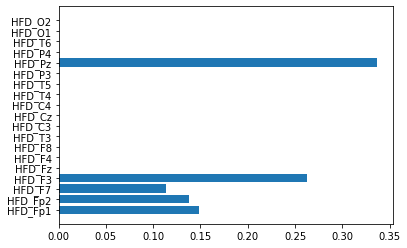

In [ ]:
plt.barh(feature_names, xgb.feature_importances_)

In [ ]:
cols = ['HFD_Pz', 'HFD_F3','HFD_F7','HFD_Fp2','HFD_Fp1']

In [ ]:
cols = ['HFD_Pz', 'HFD_F4', 'HFD_F3','HFD_F7','HFD_Fp2','HFD_Fp1']

In [ ]:
dfa = pd.read_csv('/content/drive/My Drive/eeg autism/control_female/hfd_control_female/control_female_128.csv') 
dfa = dfa[cols]
#print(dfa)
x = dfa.iloc[ : , :].values
print('Average hfd of control female after channel reduction:', x.mean())
print('Minimum hfd of control female after channel reduction:', x.min())
print('Maximum hfd of control female after channel reduction:', x.max())
print('Standard deviation of hfd of control female after channel reduction:', x.std())

Average hfd of control female after channel reduction: 1.6488360904092225
Minimum hfd of control female after channel reduction: 1.4697073987177214
Maximum hfd of control female after channel reduction: 1.7886382114993713
Standard deviation of hfd of control female after channel reduction: 0.08978738770613016


In [ ]:
dfa = pd.read_csv('/content/drive/My Drive/eeg autism/control_male/hfd_control_male/control_male_128.csv') 
dfa = dfa[cols]
x = dfa.iloc[ : , :].values
print(type(x))
print('Average hfd of control male after channel reduction:', x.mean())
print('Minimum hfd of control male after channel reduction:', x.min())
print('Maximum hfd of control male after channel reduction:', x.max())
print('Standard deviation of hfd of control male after channel reduction:', x.std())

<class 'numpy.ndarray'>
Average hfd of control male after channel reduction: 1.717273633559635
Minimum hfd of control male after channel reduction: 1.5763130088096382
Maximum hfd of control male after channel reduction: 1.8330962326343847
Standard deviation of hfd of control male after channel reduction: 0.07889124356510399


In [ ]:
dfa = pd.read_csv('/content/drive/My Drive/eeg autism/ASD_male/hfd_ASD_male/ASD_male_128.csv') 
dfa = dfa[cols]
x = dfa.iloc[ : , :].values
print(type(x))
print('Average hfd of ASD male after channel reduction:', x.mean())
print('Minimum hfd of ASD male after channel reduction:', x.min())
print('Maximum hfd of ASD male after channel reduction:', x.max())
print('Standard deviation of hfd of ASD male after channel reduction:', x.std())

<class 'numpy.ndarray'>
Average hfd of ASD male after channel reduction: 1.6153685285149542
Minimum hfd of ASD male after channel reduction: 1.189656077062856
Maximum hfd of ASD male after channel reduction: 1.838776088694081
Standard deviation of hfd of ASD male after channel reduction: 0.2032998216077533


In [ ]:
dfa = pd.read_csv('/content/drive/My Drive/eeg autism/ASD_female/hfd_ASD_female/ASD_female_128.csv') 
dfa = dfa[cols]
x = dfa.iloc[ : , :].values
print(type(x))
print('Average hfd of ASD female after channel reduction:', x.mean())
print('Minimum hfd of ASD female after channel reduction:', x.min())
print('Maximum hfd of ASD female after channel reduction:', x.max())
print('Standard deviation of hfd of ASD female after channel reduction:', x.std())

<class 'numpy.ndarray'>
Average hfd of ASD female after channel reduction: 1.6173648338443125
Minimum hfd of ASD female after channel reduction: 1.189656077062856
Maximum hfd of ASD female after channel reduction: 1.8696213460596416
Standard deviation of hfd of ASD female after channel reduction: 0.26936626247208173


**Paper implementation**


In [ ]:
content = pd.read_csv('/content/drive/My Drive/EEG/S1 dataset.csv') 
content

,Subj_Nr,MMSE,Age,NCC,Fp2_1HFD,Fp1_2HFD,F8_3HFD,F4_4HFD,AFz_5HFD,F3_6HFD,F7_7HFD,T4_8HFD,C4_9HFD,Cz_10HFD,C3_11HFD,T3_12HFD,P8_13HFD,P4_14HFD,Pz_15HFD,P3_16HFD,P7_17HFD,O2_18HFD,O1_19HFD
0,1,26.7,72,NaN,1.904643,1.882087,1.906460,1.889145,1.913572,1.906051,1.902707,1.910255,1.891880,1.882256,1.890342,1.865956,1.842187,1.855877,1.823476,1.927981,1.930361,1.871560,1.915063
1,2,26.0,58,-1.67,1.952997,1.929116,1.961742,1.898477,1.950606,1.956320,1.937859,1.948041,1.945383,1.955633,1.919391,1.950389,1.918779,1.914717,1.903432,1.934717,1.920104,1.909337,1.920088
2,3,27.3,70,0.13,1.894784,1.897989,1.913154,1.925032,1.902516,1.911998,1.903091,1.895287,1.892265,1.898225,1.892538,1.856657,1.895901,1.895469,1.915617,1.910297,1.904193,1.908261,1.901122
3,4,24.5,81,0.58,1.881242,1.864115,1.855803,1.825493,1.908128,1.918593,1.907512,1.896098,1.909410,1.896115,1.874742,1.736619,1.654324,1.792912,1.676708,1.881036,1.865412,1.894645,1.840504
4,5,12.5,61,6.55,1.792394,1.791498,1.810769,1.829104,1.810158,1.816606,1.809482,1.818058,1.808307,1.805461,1.814248,1.778556,1.737943,1.746396,1.745587,1.817848,1.832145,1.837056,1.833624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,104,NaN,28,NaN,1.919830,1.921930,1.910085,1.950414,1.917450,1.921750,1.914920,1.921610,1.926290,1.925127,1.960184,1.920801,1.926500,1.928810,1.916100,1.927160,1.913360,1.900002,1.925900
104,105,NaN,49,NaN,1.939376,1.943276,1.920989,1.939898,1.944215,1.943349,1.921688,1.926229,1.943929,1.938498,1.951551,1.921651,1.948053,1.947223,1.938489,1.949042,1.951016,1.961452,1.962214
105,106,NaN,38,NaN,1.937679,1.941503,1.954287,1.938111,1.936715,1.943115,1.945212,1.941364,1.949378,1.937136,1.948992,1.940864,1.936059,1.941656,1.934285,1.942908,1.930219,1.931820,1.931151
106,107,NaN,26,NaN,1.932923,1.921932,1.918232,1.927876,1.917454,1.921745,1.922109,1.922633,1.936529,1.929059,1.939313,1.929812,1.926500,1.928808,1.938383,1.929962,1.913362,1.928249,1.925901


In [ ]:
content1 = content


In [ ]:
df3 = content[content['MMSE'].notna()]


In [ ]:
df4 = content[content['NCC'].notna()]


In [ ]:
content['MMSE'] = content['MMSE'].replace(np.nan, 1000)
content 

,Subj_Nr,MMSE,Age,NCC,Fp2_1HFD,Fp1_2HFD,F8_3HFD,F4_4HFD,AFz_5HFD,F3_6HFD,F7_7HFD,T4_8HFD,C4_9HFD,Cz_10HFD,C3_11HFD,T3_12HFD,P8_13HFD,P4_14HFD,Pz_15HFD,P3_16HFD,P7_17HFD,O2_18HFD,O1_19HFD
0,1,26.7,72,NaN,1.904643,1.882087,1.906460,1.889145,1.913572,1.906051,1.902707,1.910255,1.891880,1.882256,1.890342,1.865956,1.842187,1.855877,1.823476,1.927981,1.930361,1.871560,1.915063
1,2,26.0,58,-1.67,1.952997,1.929116,1.961742,1.898477,1.950606,1.956320,1.937859,1.948041,1.945383,1.955633,1.919391,1.950389,1.918779,1.914717,1.903432,1.934717,1.920104,1.909337,1.920088
2,3,27.3,70,0.13,1.894784,1.897989,1.913154,1.925032,1.902516,1.911998,1.903091,1.895287,1.892265,1.898225,1.892538,1.856657,1.895901,1.895469,1.915617,1.910297,1.904193,1.908261,1.901122
3,4,24.5,81,0.58,1.881242,1.864115,1.855803,1.825493,1.908128,1.918593,1.907512,1.896098,1.909410,1.896115,1.874742,1.736619,1.654324,1.792912,1.676708,1.881036,1.865412,1.894645,1.840504
4,5,12.5,61,6.55,1.792394,1.791498,1.810769,1.829104,1.810158,1.816606,1.809482,1.818058,1.808307,1.805461,1.814248,1.778556,1.737943,1.746396,1.745587,1.817848,1.832145,1.837056,1.833624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,104,1000.0,28,NaN,1.919830,1.921930,1.910085,1.950414,1.917450,1.921750,1.914920,1.921610,1.926290,1.925127,1.960184,1.920801,1.926500,1.928810,1.916100,1.927160,1.913360,1.900002,1.925900
104,105,1000.0,49,NaN,1.939376,1.943276,1.920989,1.939898,1.944215,1.943349,1.921688,1.926229,1.943929,1.938498,1.951551,1.921651,1.948053,1.947223,1.938489,1.949042,1.951016,1.961452,1.962214
105,106,1000.0,38,NaN,1.937679,1.941503,1.954287,1.938111,1.936715,1.943115,1.945212,1.941364,1.949378,1.937136,1.948992,1.940864,1.936059,1.941656,1.934285,1.942908,1.930219,1.931820,1.931151
106,107,1000.0,26,NaN,1.932923,1.921932,1.918232,1.927876,1.917454,1.921745,1.922109,1.922633,1.936529,1.929059,1.939313,1.929812,1.926500,1.928808,1.938383,1.929962,1.913362,1.928249,1.925901


In [ ]:
df1 = content[content['MMSE'] > 24 ]  # young control and elderly control

In [ ]:
df6 = df2 = content[content['MMSE'] <= 24 ]  # AD patients

In [ ]:
x1 = df1.iloc[:, 2:3].values   # healthy subjects
x2 = df3.iloc[:, 1:2].values   # AD subjects MMSE values
x3 = df4.iloc[:, 3:4].values   # AD subjects NCC values

In [ ]:
df1.drop(['Subj_Nr', 'MMSE','Age','NCC'], axis='columns', inplace=True)
df3.drop(['Subj_Nr', 'MMSE','Age','NCC'], axis='columns', inplace=True)
df4.drop(['Subj_Nr', 'MMSE','Age','NCC'], axis='columns', inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
y1 = df1.mean(axis=1)
y2 = df3.mean(axis=1)
y3 = df4.mean(axis=1)

In [ ]:
p = y1.to_numpy()
type(p)

numpy.ndarray

In [ ]:
p1 = y2.to_numpy()
type(p1)

numpy.ndarray

In [ ]:
p2 = y3.to_numpy()
type(p2)

numpy.ndarray

In [ ]:
q = x1.flatten()
q1 = x2.flatten()
q2 = x3.flatten()

In [ ]:
dafa = pd.DataFrame({'Age':q, 'AHDF':p})
dafa

,Age,AHDF
0,72,1.890098
1,58,1.933007
2,70,1.900758
3,81,1.846285
4,64,1.945928
5,72,1.930931
6,76,1.905161
7,79,1.899191
8,59,1.901935
9,64,1.925089


In [ ]:
dafa1 = pd.DataFrame({'MMSE':q1, 'AHDF':p1})
dafa1

,MMSE,AHDF
0,26.7,1.890098
1,26.0,1.933007
2,27.3,1.900758
3,24.5,1.846285
4,12.5,1.801855
...,...,...
79,12.7,1.862613
80,14.7,1.867435
81,15.0,1.896795
82,26.7,1.906660


In [ ]:
dafa2 = pd.DataFrame({'NCC':q2, 'AHDF':p2})
dafa2

,NCC,AHDF
0,-1.67,1.933007
1,0.13,1.900758
2,0.58,1.846285
3,6.55,1.801855
4,5.25,1.871801
...,...,...
78,4.59,1.862613
79,4.90,1.867435
80,5.19,1.896795
81,2.22,1.906660


In [ ]:
from scipy import stats
stats.pearsonr(dafa['Age']<24,dafa['AHDF'])

(0.13683974273446112, 0.32379710172733867)

In [ ]:
from scipy import stats
stats.pearsonr(dafa['Age'].between(40, 71) ,dafa['AHDF'])

(-0.09597989206780293, 0.489943674015716)

In [ ]:
from scipy import stats
stats.pearsonr(dafa['Age']>71 ,dafa['AHDF'])

(-0.47550321638877635, 0.0002794004917143783)

In [ ]:
from scipy import stats
stats.pearsonr(dafa1['MMSE'],dafa1['AHDF'])

(0.33846562677374614, 0.0016377137977466524)

In [ ]:
from scipy import stats
stats.pearsonr(dafa2['NCC'],dafa2['AHDF'])

(-0.2885860278061586, 0.008149383571444175)

Text(0, 0.5, 'Average Higuchis Fractal Dimension')

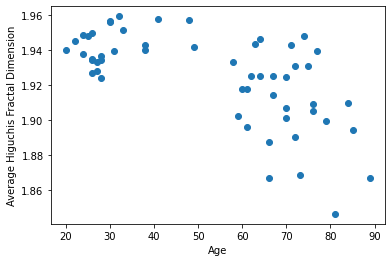

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x1, y1)
plt.xlabel('Age')
plt.ylabel('Average Higuchis Fractal Dimension')

Text(0, 0.5, 'Average Higuchis Fractal Dimension')

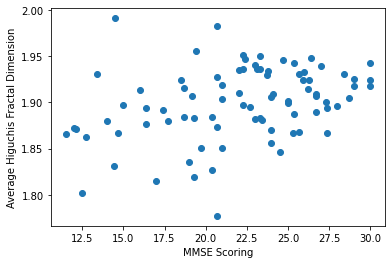

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x2, y2)
plt.xlabel('MMSE Scoring')
plt.ylabel('Average Higuchis Fractal Dimension')

Text(0, 0.5, 'Average Higuchis Fractal Dimension')

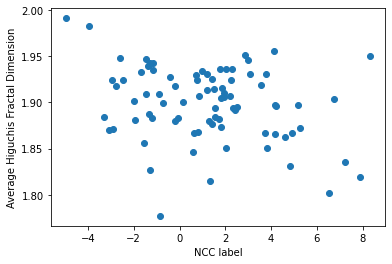

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x3, y3)
plt.xlabel('NCC label')
plt.ylabel('Average Higuchis Fractal Dimension')

In [ ]:
content

,Subj_Nr,MMSE,Age,NCC,Fp2_1HFD,Fp1_2HFD,F8_3HFD,F4_4HFD,AFz_5HFD,F3_6HFD,F7_7HFD,T4_8HFD,C4_9HFD,Cz_10HFD,C3_11HFD,T3_12HFD,P8_13HFD,P4_14HFD,Pz_15HFD,P3_16HFD,P7_17HFD,O2_18HFD,O1_19HFD
0,1,26.7,72,NaN,1.904643,1.882087,1.906460,1.889145,1.913572,1.906051,1.902707,1.910255,1.891880,1.882256,1.890342,1.865956,1.842187,1.855877,1.823476,1.927981,1.930361,1.871560,1.915063
1,2,26.0,58,-1.67,1.952997,1.929116,1.961742,1.898477,1.950606,1.956320,1.937859,1.948041,1.945383,1.955633,1.919391,1.950389,1.918779,1.914717,1.903432,1.934717,1.920104,1.909337,1.920088
2,3,27.3,70,0.13,1.894784,1.897989,1.913154,1.925032,1.902516,1.911998,1.903091,1.895287,1.892265,1.898225,1.892538,1.856657,1.895901,1.895469,1.915617,1.910297,1.904193,1.908261,1.901122
3,4,24.5,81,0.58,1.881242,1.864115,1.855803,1.825493,1.908128,1.918593,1.907512,1.896098,1.909410,1.896115,1.874742,1.736619,1.654324,1.792912,1.676708,1.881036,1.865412,1.894645,1.840504
4,5,12.5,61,6.55,1.792394,1.791498,1.810769,1.829104,1.810158,1.816606,1.809482,1.818058,1.808307,1.805461,1.814248,1.778556,1.737943,1.746396,1.745587,1.817848,1.832145,1.837056,1.833624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,104,1000.0,28,NaN,1.919830,1.921930,1.910085,1.950414,1.917450,1.921750,1.914920,1.921610,1.926290,1.925127,1.960184,1.920801,1.926500,1.928810,1.916100,1.927160,1.913360,1.900002,1.925900
104,105,1000.0,49,NaN,1.939376,1.943276,1.920989,1.939898,1.944215,1.943349,1.921688,1.926229,1.943929,1.938498,1.951551,1.921651,1.948053,1.947223,1.938489,1.949042,1.951016,1.961452,1.962214
105,106,1000.0,38,NaN,1.937679,1.941503,1.954287,1.938111,1.936715,1.943115,1.945212,1.941364,1.949378,1.937136,1.948992,1.940864,1.936059,1.941656,1.934285,1.942908,1.930219,1.931820,1.931151
106,107,1000.0,26,NaN,1.932923,1.921932,1.918232,1.927876,1.917454,1.921745,1.922109,1.922633,1.936529,1.929059,1.939313,1.929812,1.926500,1.928808,1.938383,1.929962,1.913362,1.928249,1.925901


In [ ]:
df5 = content[content['MMSE'] > 100]    # young  control
df5

,Subj_Nr,MMSE,Age,NCC,Fp2_1HFD,Fp1_2HFD,F8_3HFD,F4_4HFD,AFz_5HFD,F3_6HFD,F7_7HFD,T4_8HFD,C4_9HFD,Cz_10HFD,C3_11HFD,T3_12HFD,P8_13HFD,P4_14HFD,Pz_15HFD,P3_16HFD,P7_17HFD,O2_18HFD,O1_19HFD
84,85,1000.0,38,NaN,1.946030,1.950674,1.945363,1.944845,1.939201,1.944703,1.948600,1.937457,1.952820,1.942892,1.953168,1.941402,1.930645,1.945416,1.937067,1.937265,1.939909,1.937247,1.938870
85,86,1000.0,41,NaN,1.957665,1.959655,1.957789,1.954115,1.954682,1.954865,1.958806,1.962777,1.962896,1.952179,1.966106,1.965827,1.950515,1.960774,1.957848,1.962844,1.953869,1.950730,1.954721
86,87,1000.0,24,NaN,1.948769,1.945350,1.954344,1.938320,1.937984,1.938275,1.946308,1.951688,1.951082,1.945351,1.953828,1.947628,1.950127,1.950021,1.946260,1.956064,1.952991,1.951981,1.954356
87,88,1000.0,27,NaN,1.931542,1.929761,1.927843,1.926415,1.927549,1.936450,1.935245,1.927823,1.947148,1.921620,1.958455,1.941104,1.937596,1.930193,1.917116,1.927161,1.932928,1.934090,1.935018
88,89,1000.0,32,NaN,1.956352,1.956359,1.954743,1.958620,1.954711,1.961594,1.950434,1.954442,1.963237,1.945669,1.972238,1.956772,1.977139,1.957514,1.945765,1.960551,1.958421,1.976027,1.962775
89,90,1000.0,26,NaN,1.958028,1.948890,1.948814,1.952000,1.951806,1.943245,1.953679,1.949430,1.939926,1.937753,1.950626,1.947444,1.939871,1.955272,1.939184,1.947634,1.951132,1.957899,1.963696
90,91,1000.0,30,NaN,1.955322,1.951915,1.946852,1.961321,1.956916,1.963767,1.943051,1.941675,1.963506,1.960640,1.966581,1.951628,1.958489,1.957088,1.950834,1.957221,1.965466,1.957520,1.957762
91,92,1000.0,26,NaN,1.941655,1.935055,1.936921,1.939985,1.938501,1.935617,1.928539,1.924350,1.928770,1.924725,1.933131,1.924148,1.945341,1.945576,1.926351,1.930004,1.933989,1.945866,1.943359
92,93,1000.0,27,NaN,1.919827,1.923267,1.920827,1.923194,1.920361,1.926211,1.914922,1.926717,1.936261,1.910904,1.941968,1.917273,1.933319,1.932093,1.916095,1.931391,1.937519,1.938073,1.960702
93,94,1000.0,20,NaN,1.948941,1.944644,1.949561,1.947221,1.946282,1.946181,1.942292,1.921606,1.926293,1.912354,1.932440,1.922042,1.938586,1.945127,1.945256,1.952044,1.945492,1.942815,1.951986


In [ ]:
yc_left = (df5['C3_11HFD'].mean()+ df5['F7_7HFD'].mean() + df5['Fp1_2HFD'].mean() +df5['P7_17HFD'].mean() +df5['P3_16HFD'].mean() + df5['T3_12HFD'].mean()+ df5['O1_19HFD'].mean() +df5['F3_6HFD'].mean())/8
yc_left

1.9440272870885418

In [ ]:
yc_right = (df5['C4_9HFD'].mean() + df5['O2_18HFD'].mean()+ df5['P8_13HFD'].mean() + df5['P4_14HFD'].mean()+ df5['T4_8HFD'].mean()+ df5['Fp2_1HFD'].mean()+df5['F8_3HFD'].mean()+ df5['F4_4HFD'].mean())/8
yc_right

1.943159227947917

In [ ]:
df6 = content[(content['MMSE'].between(26, 29.2))]             #   elderly control
df6

,Subj_Nr,MMSE,Age,NCC,Fp2_1HFD,Fp1_2HFD,F8_3HFD,F4_4HFD,AFz_5HFD,F3_6HFD,F7_7HFD,T4_8HFD,C4_9HFD,Cz_10HFD,C3_11HFD,T3_12HFD,P8_13HFD,P4_14HFD,Pz_15HFD,P3_16HFD,P7_17HFD,O2_18HFD,O1_19HFD
0,1,26.7,72,NaN,1.904643,1.882087,1.906460,1.889145,1.913572,1.906051,1.902707,1.910255,1.891880,1.882256,1.890342,1.865956,1.842187,1.855877,1.823476,1.927981,1.930361,1.871560,1.915063
1,2,26.0,58,-1.67,1.952997,1.929116,1.961742,1.898477,1.950606,1.956320,1.937859,1.948041,1.945383,1.955633,1.919391,1.950389,1.918779,1.914717,1.903432,1.934717,1.920104,1.909337,1.920088
2,3,27.3,70,0.13,1.894784,1.897989,1.913154,1.925032,1.902516,1.911998,1.903091,1.895287,1.892265,1.898225,1.892538,1.856657,1.895901,1.895469,1.915617,1.910297,1.904193,1.908261,1.901122
7,8,28.4,72,3.08,1.934811,1.939596,1.897990,1.983000,1.933527,1.940071,1.933345,1.927592,1.876009,1.892479,1.934370,1.909269,1.908170,1.921759,1.954123,1.938410,1.965564,1.932602,1.965000
8,9,28.7,76,1.81,1.897573,1.924380,1.911799,1.898369,1.912576,1.921172,1.889154,1.904668,1.906757,1.920206,1.902369,1.919656,1.880501,1.892031,1.897128,1.896983,1.911603,1.906891,1.904234
26,27,29.0,64,1.40,1.925179,1.926475,1.934542,1.930991,1.953602,1.939248,1.929616,1.942847,1.925396,1.922172,1.936573,1.866503,1.888468,1.864437,1.919698,1.946180,1.934749,1.946264,1.943759
28,29,27.0,77,-1.37,1.956079,1.945023,1.937799,1.915083,1.962905,1.958544,1.946866,1.947426,1.936175,1.951453,1.921082,1.936979,1.963118,1.905441,1.904139,1.944260,1.926694,1.952871,1.939294
29,30,27.4,89,0.65,1.904640,1.882090,1.828020,1.886470,1.895370,1.906050,1.895430,1.888730,1.854910,1.830220,1.865840,1.861440,1.842190,1.796150,1.799719,1.909270,1.862800,1.871560,1.892940
30,31,26.7,76,-0.88,1.910784,1.911711,1.984494,1.895495,1.934546,1.913168,1.948147,1.931574,1.854913,1.830220,1.865841,1.861443,1.898909,1.889445,1.860791,1.966571,1.937254,1.939068,1.935299
31,32,29.0,60,-0.19,1.916619,1.914435,1.916681,1.956340,1.925262,1.924820,1.930712,1.924309,1.934484,1.926588,1.938279,1.897890,1.876775,1.851156,1.859026,1.936075,1.929070,1.944343,1.930185


In [ ]:
Ec_left = (df6['C3_11HFD'].mean()+ df6['F7_7HFD'].mean() + df6['Fp1_2HFD'].mean() +df6['P7_17HFD'].mean() +df6['P3_16HFD'].mean() + df6['T3_12HFD'].mean()+ df6['O1_19HFD'].mean() +df6['F3_6HFD'].mean())/8
Ec_left

1.91647303975

In [ ]:
Ec_right = (df6['C4_9HFD'].mean() + df6['O2_18HFD'].mean()+ df6['P8_13HFD'].mean() + df6['P4_14HFD'].mean()+ df6['T4_8HFD'].mean()+ df6['Fp2_1HFD'].mean()+df6['F8_3HFD'].mean()+ df6['F4_4HFD'].mean())/8
Ec_right

1.9110114066484374

In [ ]:
    # young and elderly control
df7 = content[content['MMSE']<= 24.85 ]            #elderly control
df7.shape

(57, 23)

In [ ]:
AD_left = (df7['C3_11HFD'].mean()+ df7['F7_7HFD'].mean() + df7['Fp1_2HFD'].mean() +df7['P7_17HFD'].mean() +df7['P3_16HFD'].mean() + df7['T3_12HFD'].mean()+ df7['O1_19HFD'].mean() +df7['F3_6HFD'].mean())/8
AD_left

1.8979720210548245

In [ ]:
AD_right = (df7['C4_9HFD'].mean() + df7['O2_18HFD'].mean()+ df7['P8_13HFD'].mean() + df7['P4_14HFD'].mean()+ df7['T4_8HFD'].mean()+ df7['Fp2_1HFD'].mean()+df7['F8_3HFD'].mean()+ df7['F4_4HFD'].mean())/8
AD_right

1.891888989993421

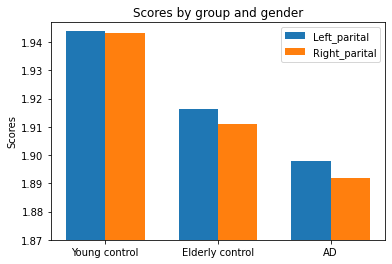

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Young control', 'Elderly control', 'AD']
Left_parital = [yc_left, Ec_left, AD_left]
Right_parital = [yc_right, Ec_right, AD_right]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Left_parital, width, label='Left_parital')
rects2 = ax.bar(x + width/2, Right_parital, width, label='Right_parital')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([1.87, 1.947])
ax.legend()
plt.show()

In [ ]:
Fp2 = df5.iloc[:, 4:5].values          #frontal left: Fp1, F7, F3; frontal right: Fp2, F4, F8
Fp1 = df5.iloc[:, 5:6].values
HArs_of_Fp = (Fp1-Fp2) / (Fp1+Fp2)

F7 = df5.iloc[:, 10:11].values
F4 = df5.iloc[:, 7:8].values
HArs_of_F7_F4 = (F7-F4) / (F7+F4)

F3 = df5.iloc[:, 9:10].values
F8 = df5.iloc[:, 6:7].values
HArs_of_F3_F8 = (F3-F8) / (F3+F8)

c3 = df5.iloc[:, 14:15].values
c4 = df5.iloc[:, 12:13].values
HArs_of_c3_c4 = (c3-c4) / (c3+c4)

t3 = df5.iloc[:, 15:16].values
t4 = df5.iloc[:, 11:12].values
HArs_of_t3_t4 = (t3-t4) / (t3+t4)

p3 = df5.iloc[:, 20:21].values
p4 = df5.iloc[:, 18:19].values
p7 = df5.iloc[:, 21:22].values
p8 = df5.iloc[:, 17:18].values
HArs_of_p3_p4 = (p3-p4) / (p3+p4)
HArs_of_p7_p8 = (p7-p8) / (p7+p8)

o1 = df5.iloc[:, 22:23].values
o2 = df5.iloc[:, 21:22].values
HArs_of_o1_o2 = (o1-o2) / (o1+o2)

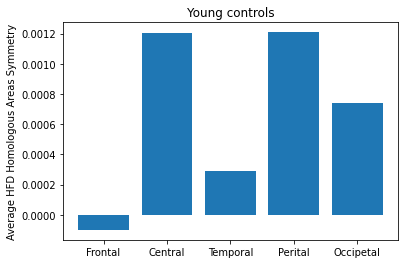

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = [(HArs_of_F3_F8.mean() + HArs_of_Fp.mean() + HArs_of_F7_F4.mean())/3,HArs_of_c3_c4.mean(),HArs_of_t3_t4.mean(),(HArs_of_p7_p8.mean()+ HArs_of_p3_p4.mean())/2 ,HArs_of_o1_o2.mean()]
plt.bar(['Frontal','Central','Temporal','Perital','Occipetal'], data)
plt.title("Young controls")
plt.ylabel('Average HFD Homologous Areas Symmetry')
plt.show()

In [ ]:
Fp2 = df6.iloc[:, 4:5].values          #frontal left: Fp1, F7, F3; frontal right: Fp2, F4, F8
Fp1 = df6.iloc[:, 5:6].values
HArs_of_Fp = (Fp1-Fp2) / (Fp1+Fp2)

F7 = df6.iloc[:, 10:11].values
F4 = df6.iloc[:, 7:8].values
HArs_of_F7_F4 = (F7-F4) / (F7+F4)

F3 = df6.iloc[:, 9:10].values
F8 = df6.iloc[:, 6:7].values
HArs_of_F3_F8 = (F3-F8) / (F3+F8)

c3 = df6.iloc[:, 14:15].values
c4 = df6.iloc[:, 12:13].values
HArs_of_c3_c4 = (c3-c4) / (c3+c4)

t3 = df6.iloc[:, 15:16].values
t4 = df6.iloc[:, 11:12].values
HArs_of_t3_t4 = (t3-t4) / (t3+t4)

p3 = df6.iloc[:, 20:21].values
p4 = df6.iloc[:, 18:19].values
p7 = df6.iloc[:, 21:22].values
p8 = df6.iloc[:, 17:18].values
HArs_of_p3_p4 = (p3-p4) / (p3+p4)
HArs_of_p7_p8 = (p7-p8) / (p7+p8)

o1 = df6.iloc[:, 22:23].values
o2 = df6.iloc[:, 21:22].values
HArs_of_o1_o2 = (o1-o2) / (o1+o2)

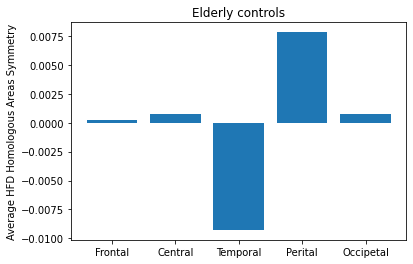

In [ ]:
data = [(HArs_of_F3_F8.mean() + HArs_of_Fp.mean() + HArs_of_F7_F4.mean())/3,HArs_of_c3_c4.mean(),HArs_of_t3_t4.mean(),(HArs_of_p7_p8.mean()+ HArs_of_p3_p4.mean())/2 ,HArs_of_o1_o2.mean()]
plt.bar(['Frontal','Central','Temporal','Perital','Occipetal'], data)
plt.title("Elderly controls")
plt.ylabel('Average HFD Homologous Areas Symmetry')
plt.show()

In [ ]:
Fp2 = df7.iloc[:, 4:5].values          #frontal left: Fp1, F7, F3; frontal right: Fp2, F4, F8
Fp1 = df7.iloc[:, 5:6].values
HArs_of_Fp = (Fp1-Fp2) / (Fp1+Fp2)

F7 = df7.iloc[:, 10:11].values
F4 = df7.iloc[:, 7:8].values
HArs_of_F7_F4 = (F7-F4) / (F7+F4)

F3 = df7.iloc[:, 9:10].values
F8 = df7.iloc[:, 6:7].values
HArs_of_F3_F8 = (F3-F8) / (F3+F8)

c3 = df7.iloc[:, 14:15].values
c4 = df7.iloc[:, 12:13].values
HArs_of_c3_c4 = (c3-c4) / (c3+c4)

t3 = df7.iloc[:, 15:16].values
t4 = df7.iloc[:, 11:12].values
HArs_of_t3_t4 = (t3-t4) / (t3+t4)

p3 = df7.iloc[:, 20:21].values
p4 = df7.iloc[:, 18:19].values
p7 = df7.iloc[:, 21:22].values
p8 = df7.iloc[:, 17:18].values
HArs_of_p3_p4 = (p3-p4) / (p3+p4)
HArs_of_p7_p8 = (p7-p8) / (p7+p8)

o1 = df7.iloc[:, 22:23].values
o2 = df7.iloc[:, 21:22].values
HArs_of_o1_o2 = (o1-o2) / (o1+o2)

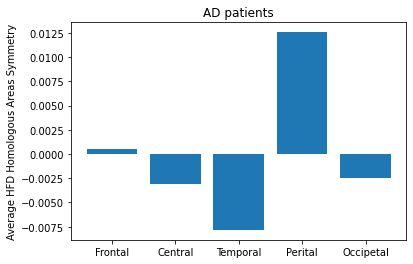

In [ ]:
data = [(HArs_of_F3_F8.mean() + HArs_of_Fp.mean() + HArs_of_F7_F4.mean())/3,HArs_of_c3_c4.mean(),HArs_of_t3_t4.mean(),(HArs_of_p7_p8.mean()+ HArs_of_p3_p4.mean())/2 ,HArs_of_o1_o2.mean()]
plt.bar(['Frontal','Central','Temporal','Perital','Occipetal'], data)
plt.title("AD patients")
plt.ylabel('Average HFD Homologous Areas Symmetry')
plt.show()